# Intro

1. The **goal** of this notebook is to **implement on policy Monte Carlo** algorithms for reinforcement learning.
2. The convergence for these algorithms where proven around 2000: See https://sites.ualberta.ca/~szepesva/papers/sarsa98.ps.pdf

In [1]:
# import useful modules
import numpy as np
import math
import random
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

# set up Gymnasium
import gymnasium as gym
from gymnasium import envs

# 0. Functions & Algorithms

## 0.1. Functions

In [14]:
def bj_encode(state):
    """
    Encodes a blackjack state into an integer.

    Parameters:
    - state: A list representing the state [i, j, b], where:
        * i: Number of points in the player's hand (1 <= i <= 31).
        * j: Number of points visible from the opponent's hand (1 <= j <= 10).
        * b: Boolean indicating whether the player has a usable ace.

    Returns:
    - An integer representing the encoded state.
    """
    if state[2]:  # If the player has a usable ace
        return state[0] + state[1] * max_sum
    else:  # If the player does not have a usable ace
        return state[0] + state[1] * max_sum + max_sum * max_opp_score
 

def bj_decode(index):
    """
    Decodes an integer back into a blackjack state.

    Parameters:
    - index: An integer representing the encoded state.

    Returns:
    - A list representing the decoded state [i, j, b], where:
        * i: Number of points in the player's hand.
        * j: Number of points visible from the opponent's hand.
        * b: Boolean indicating whether the player has a usable ace.
    """
    state = [0, 0, 0]  # Initialize the state
    if index > max_sum * max_opp_score:
        state[2] = False  # Player does not have a usable ace
        index -= max_sum * max_opp_score
    else:
        state[2] = True  # Player has a usable ace
    
    state[0] = index % max_sum  # Decode points in the player's hand
    state[1] = index // max_sum  # Decode points visible from opponent's hand
    return state

def fz_encode(state):
  return state

def fz_decode(state):
  return state

In [39]:
def draw(policy, state_index):
  """
  Draw an action for a given state by following the distribution of action probabilities of this state.

  Args:
    - policy (numpy.array): the policy i.e. the mapping (states: actions)
    - state (int): the index of the state
  
  Returns:
    action (int): the number / index of the action for the given state index
  """

  return np.random.choice(a = policy[state_index].shape[0], p = policy[state_index])

In [4]:
def update_eps_greedy_policy(epsilon, q):
  """
  This function update a policy for a given state, following the espilon_greedy strategy.
    Let a* = argmax_a[q(s, a)]. If a* is not unique, we randomly chose one
    -  If a = a*, state_policy(s, a) = 1 - ϵ + (ϵ / nb_actions).
    -  If not, state_policy(s, a) = ϵ / nb_actions.
  
  Args:
    epsilon (float): greedy parameter
    q (numpy.array): Q-values

  Returns:
    policy (numpy.array): the updated policy. the probability distribution for the given state    
  """
  # Compute argmax values
  q_argmax = np.argmax(q, axis = 1)

  # i.e. updating policy for other actions
  policy = np.full(shape=q.shape, fill_value = epsilon / q.shape[1]) 

  # updating policy for argmax actions
  policy[np.arange(q.shape[0]), q_argmax] = 1 - epsilon + (epsilon / q.shape[1]) # i.e. 
  
  return policy

In [140]:
def plot_moving_averages(rewards_dict, nb_episodes, moving_avg_size):
    """
    Plots the moving averages of rewards for multiple reward histories on the same graph, 
    with named histories provided in a dictionary.

    Args:
        - rewards_dict (dict): A dictionary where keys are names of the reward histories 
          and values are the corresponding lists of rewards.
        - moving_avg_size (int, optional): The size of the moving average window. Default is 20.

    Returns:
        None
    """
    plt.figure(figsize=(12, 8))
    
    # Loop through each rewards history in the dictionary and compute the moving average
    for name, rewards in rewards_dict.items():
        
        # Calculate the moving average by sliding the kernel k = [1/moving_avg_size] * moving_avg_size
        moving_avg_rewards = np.convolve(rewards, np.ones(moving_avg_size) / moving_avg_size, mode='valid')

        plt.plot(
            range(len(moving_avg_rewards)), 
            moving_avg_rewards, 
            label=name
        )

    # Add labels, title, legend, and grid
    plt.xlabel("Number of Episodes - Moving Average Window Size")
    plt.ylabel("Moving Average of Rewards")
    plt.title(f"Comparison of {moving_avg_size}-Episode Moving Averages Across Reward Histories (trained on {nb_episodes} episodes)")
    plt.legend()
    plt.grid()
    plt.show()

## 0.2. Algorithms

In [196]:
def on_policy_monte_carlo(
    env,
    nb_states,
    nb_actions,
    encode_fct,
    nb_episodes=20000,
    gamma=1,
    epsilon=0.1,
    use_glei=False,
    decay_rate = 0.2,
    min_epsilon=0.05
):
    """
    This algorithm goal is to find the optimal policy in a episodic environement with reasonable number of states and actions
    Convergence guaranteed in this paper: https://sites.ualberta.ca/~szepesva/papers/sarsa98.ps.pdf
    
    Repeat for the given number of episodes:
        Simulate an episode with the given policy
        Compute the accumulated rewards with discount factor (gamma): G
        For every visited q(s, a) in the current episode:
            If first visit of (s, a) is at iteration t:
                acc(s, a) += Gt
                count(s, a) += 1
                q(s, a) = acc(s, a) / count(s, a)
            For every state in the current episode:
                update policy(s, a) with an epsilon greedy strategy or GLEI strategy
    
    Args:
        - env (gymnasium.Env): a gymnasium environment
        - nb_states (int): the number of states for the given env
        - nb_actions (int): the number of actions for the given env
        - encode_fct (callable): the function to encode our state.
        - nb_episodes (int): number of episodes simulated for learning
        - gamma (float): discount factor for updating states values
        - epsilon (float): initial exploration factor, in [0, 1], if use_gley = True, represent the starting epsilon
        - use_glei (bool): if True, use GLEI policy (decaying epsilon across episodes); if False, use simple epsilon-greedy
        - decay_rate (float): Every time num_episode > nb_episode * (decay_rate *i) then epsilon = epsilon * (1 - decay_rate) * i. Where i is the number of time we decayed epsilon
        - min_epsilon (float): the minimum decayed epsilon when using a GLEI policy

    Returns:
        - policy (numpy.array): the learnt policy
        - q (numpy.array): the Q-values
        - rewards_historic (list): the historic of rewards during training
    """
    # Initialize algorithm variables
    q = np.zeros(shape=(nb_states, nb_actions))  # (state, action) values through every episodes generated
    count = np.zeros(shape=(nb_states, nb_actions))  # Counting each (s, a) events through every episodes generated
    acc = np.zeros(shape=(nb_states, nb_actions))  # (state, action) cumulated values through every episodes generated
    policy = np.full(shape=(nb_states, nb_actions), fill_value=1 / nb_actions)  # Actions probabilities for each state. Initialized as a uniform policy
    rewards_historic = []
    if use_glei: # If we use a GLEI policy, set up glei_epsilon i.e. starting epsilon
        glei_epsilon = epsilon
        count_decay = 1

    for num_episode in range(nb_episodes):
        # print(f"Computing ep {num_episode}")
        
        # Initialize environment
        game_state = env.reset()[0]  # A tuple (player score, opponent score, ace (1) or not (0))
        terminated = False
        G = np.empty((0, 1))  # Cumulated rewards of the current episode
        moves_historic = np.empty((0, 2), dtype=int)  # Historic of (state, action) of the current episode
        
        # Step 1: Simulate an episode
        while not terminated:
            # Draw an action according to the current policy
            state_index = encode_fct(game_state)
            
            # Action selection with epsilon-greedy or GLEI
            action = draw(policy, state_index)

            # Update environment with the chosen action
            env_state = env.step(action)
            game_state, G, terminated = env_state[0], np.append(G, env_state[1]), env_state[2]

            # Update current historic if current (state, action) was not visited yet
            moves_historic = np.append(moves_historic, [[state_index, action]], axis=0)

        # Update rewards_historic with the total reward of the episode
        rewards_historic.append(np.sum(G))

        # Step 2: Compute G, the cumulative rewards for each state
        gamma_powers = gamma ** np.arange(len(G))
        for i in range(len(G) - 1):
            G[i] = np.sum(
                G[i:] * gamma_powers[:len(G[i:])]
            )

        # Step 3: For every (s, a) visited: Update q(s, a)
        # Extracting first visit for every (s, a)
        first_visit_states_action, first_visit_indices = np.unique(moves_historic, axis=0, return_index=True)
        first_visit_indices = np.sort(first_visit_indices)

        # Extract relevant states, actions, and rewards for first visits
        states = moves_historic[first_visit_indices, 0]
        actions = moves_historic[first_visit_indices, 1]
        rewards = G[first_visit_indices]

        # Update acc, count, and q arrays
        np.add.at(acc, (states, actions), rewards)  # Accumulate rewards
        np.add.at(count, (states, actions), 1)      # Increment count
        q = np.divide(acc, count, where=(count != 0), out=np.zeros_like(acc))

        # Step 4: Update policy with the current Q-values
        if use_glei:
            # GLEI policy update: Use epsilon-greedy strategy with decaying epsilon over episodes
            policy = update_eps_greedy_policy(epsilon=glei_epsilon, q=q)

            # Decay epsilon after each episode, but ensure it doesn't go below the minimum
            if num_episode > (decay_rate * count_decay) * nb_episodes:
                glei_epsilon = max(glei_epsilon * (1 - (decay_rate * count_decay)), min_epsilon)
                count_decay += 1
            
        else:
            # Standard epsilon-greedy policy
            policy = update_eps_greedy_policy(epsilon=epsilon, q=q)

    if use_glei: print(f"Final epsilon: {glei_epsilon}")
    return policy, q, rewards_historic

In [79]:
def every_visit_monte_carlo(env, nb_states, nb_actions, policy, encode_fct, nb_episodes = 1000, gamma = 1):
    """
    - "Every visit" version of Monte Carlo algorithm which consists of evaluating a given policy.
    - This version of the algorithm raises the problem that the values q(s, a) are not necessarily i.i.d.
      Indeed, visiting the same state multiple times during an episode is certainly dependent on the episode's history.
      Convergence despite dependance is guaranteed in this paper: https://sites.ualberta.ca/~szepesva/papers/sarsa98.ps.pdf
    - Repeat for the given number of episodes:
        Simulate an episode with the given policy
        Compute the accumulated rewards with discount factor (gamma): G
        For every visited q(s, a) at iteration t in the current episode:
            acc(s, a) += Gt
            count(s, a) += 1
            q(s, a) = acc(s, a) / count(s, a)

    Args:
        - env (gymnasium.Env): the gymnasiuù environment
        - nb_sates (int): number of states of env
        - nb_actions (int): number of actions possible
        - nb_episodes (int): number of episodes simulated
        - policy (numpy.array): the probabilities of chosing each action for each state
        - encode_fct (callable): the function to encode the game state
    
    Returns:
        - q (numpy.array 2D): the array of values q(states, actions)
        - v (numpy.array 1D): the array of values v(states) which is the max_a[q(s, a)]
    """
    # Initializing algorithm variables
    q = np.zeros(shape = (nb_states, nb_actions)) # (state, action) values through every episodes generated
    count = np.zeros(shape = (nb_states, nb_actions)) # Counting each (s, a) events through every episodes generated
    acc = np.zeros(shape = (nb_states, nb_actions)) # (state, action) cumulated values through every episodes generated
    rewards_historic = []
    # Repeat for the given number of 
    for i in range(nb_episodes):
        # Initializing environment
        game_state = env.reset()[0] # A tuple (player score, opponent score, ace (1) or not (0))
        terminated = False
        G = np.empty((0, 1)) # Cumulated rewards for the current episode
        moves_historic = np.empty((0, 2), dtype=int)  # Historic of (state, action) of the current episode

        # Step 1: Simulating an episode
        while not(terminated):
           # Draw an action according to the current state
            state_index = encode_fct(game_state)
            action = draw(policy, state_index)

            # Updating variables according to the action chosen
            env_state = env.step(action)
            game_state, G, terminated = env_state[0], np.append(G, env_state[1]), env_state[2]

            # Update current historic if current (state, action) was not visited yet
            moves_historic = np.append(moves_historic, [[state_index, action]], axis = 0)

        # Update rewards historic with the total reward of the episode
        rewards_historic.append(np.sum(G))

        # Step 2: Compute G, the cumulative rewards for each state
        gamma_powers = gamma ** np.arange(len(G))
        for i in range(len(G) - 1):
            G[i] = np.sum( 
                G[i:] * gamma_powers[:len(G[i:])]
            )

        # Step 3: Update acc, count and q arrays
        # Extract states, actions
        states = moves_historic[:, 0]
        actions = moves_historic[:, 1]

        np.add.at(acc, (states, actions), G)  # Accumulate rewards
        np.add.at(count, (states, actions), 1)      # Increment count
        q = np.divide(acc, count, where  = (count != 0), out = np.zeros_like(acc)) # Q-values
    
    return q, np.max(q, axis = 1), rewards_historic

# 2. Frozen Lake

We will now try to use our "on policy Monte Carlo" implementation on the gymnasium frozen lake environement.  
See: https://www.gymlibrary.dev/environments/toy_text/frozen_lake/

## 2.1. Setting up environement

In [44]:
fz_env = gym.make("FrozenLake-v1", is_slippery = False)
fz_nb_actions = fz_env.action_space.n
fz_nb_states = fz_env.observation_space.n

print("there are ", fz_nb_actions, "actions")
print("observation space: ", fz_env.observation_space)
print("there are ", fz_nb_states, "states")

there are  4 actions
observation space:  Discrete(16)
there are  16 states


## 2.2. On policy Monte Carlo: learning an optimal policy

In [213]:
# Learning a policy

fz_policy, fz_q, fz_rewards_historic = on_policy_monte_carlo(
    env=fz_env,
    nb_states=fz_nb_states,
    nb_actions=fz_nb_actions,
    nb_episodes=30000,
    encode_fct=fz_encode,
    epsilon=0.4,
)

fz_v = np.max(fz_q, axis=1)
print(f"v:\n{fz_v}")
print(f"policy:\n{fz_policy}")

v:
[0.51931049 0.59729245 0.62145254 0.5984543  0.50158547 0.
 0.80201037 0.         0.63826816 0.82452243 0.95740127 0.
 0.         0.96313507 1.         0.        ]
policy:
[[0.1 0.1 0.7 0.1]
 [0.1 0.1 0.7 0.1]
 [0.1 0.7 0.1 0.1]
 [0.7 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.7]
 [0.7 0.1 0.1 0.1]
 [0.1 0.7 0.1 0.1]
 [0.7 0.1 0.1 0.1]
 [0.1 0.1 0.7 0.1]
 [0.1 0.7 0.1 0.1]
 [0.1 0.7 0.1 0.1]
 [0.7 0.1 0.1 0.1]
 [0.7 0.1 0.1 0.1]
 [0.1 0.1 0.7 0.1]
 [0.1 0.1 0.7 0.1]
 [0.7 0.1 0.1 0.1]]


In [178]:
# Evaluating our policy

fz_env_spec = gym.make("FrozenLake-v1", render_mode = "human", is_slippery = False)

q, v, rewards_historic = every_visit_monte_carlo(
    env=fz_env, # use fz_env_spec to display the game in graphic interface
    nb_states=fz_nb_states,
    nb_actions=fz_nb_actions,
    policy=fz_policy,
    encode_fct=fz_encode,
)

print(f"Average Reward: {np.mean(rewards_historic)}")
print(f"Number of game won: {len([x for x in rewards_historic if x == 1])}")

Average Reward: 0.532
Number of game won: 532


## 2.2. Tuning hyper parameters

**We can try to do some experiments in order to find the best hyper parameters (gamma, epsilon, nb of episodes for training).
Here, I will only focus on a quick focus on impacts of epsilon variation on the speed of convergence et the worthness of exploration for the environment of Frozen Lake.**  

**Indeed, I don't want to spend too much time on this algorithm in order to go on a more complexe algo such as SARSA, Q-Learning, Semi gradient SARSA and Deep Q-Learning.**

### 2.2.1. Compute data with simple eps-greedy policy

In [ ]:
fz_epsilon_data = dict()
nb_episodes = 100000

for eps in [0.1, 0.2, 0.3, 0.4, 0.5]:
# for eps in [0.5]:
    print(f"Computing data for epsilon = {str(eps)}")
    _, _, rewards_historic = on_policy_monte_carlo(
        env=fz_env,
        nb_states=fz_nb_states,
        nb_actions=fz_nb_actions,
        nb_episodes=nb_episodes,
        encode_fct=fz_encode,
        epsilon=eps
    )
    fz_epsilon_data[f"eps = {str(eps)}"] =  rewards_historic

Computing data for epsilon = 0.1
100000 episodes computed
Computing data for epsilon = 0.2
100000 episodes computed
Computing data for epsilon = 0.3
100000 episodes computed
Computing data for epsilon = 0.4
100000 episodes computed
Computing data for epsilon = 0.5
100000 episodes computed


**We must keep in mind that our epsilon is fix in our case. More analyzes could be interesing with a GLEI policy.  
Here, it is not surprising that, with a small epsilon, when the algo finds a rewards, the convergence get really fast because
the policy becomes way less "soft".**

**We see that 0.1 epsilon converges better, based on the reward average.  
However, we could push the analyze and show that, on average, 0.1 epsilon can take much more time to converge.  
On the opposite, higher epsilon training converge much faster but with a less optimal reward average.**  *
  
**We could also analyse the variations of gamma, etc.**

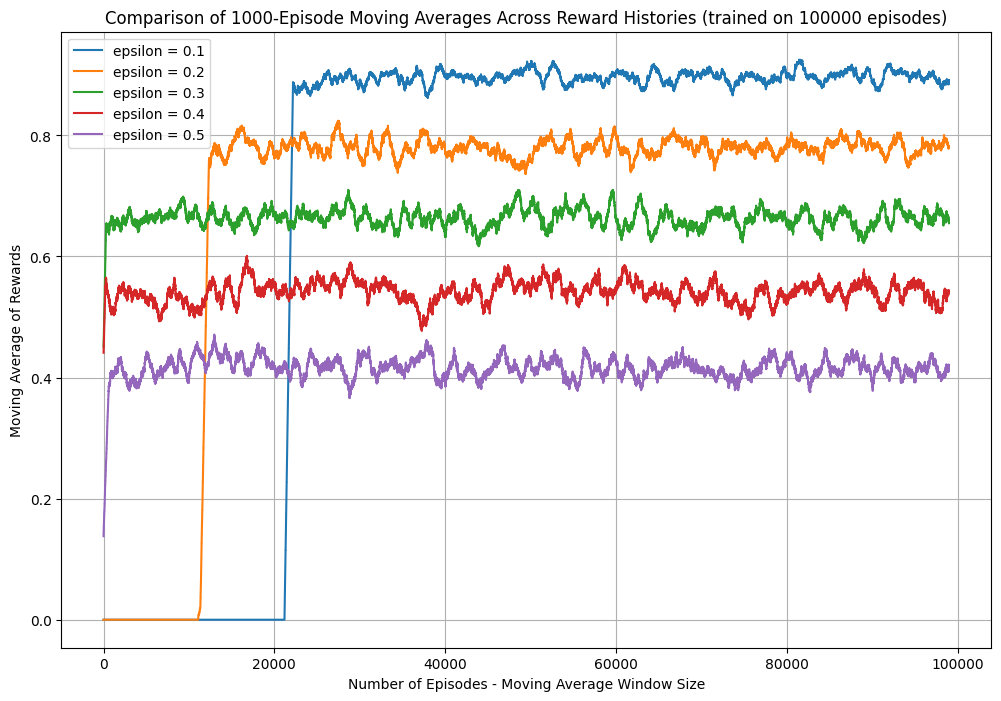

In [ ]:
plot_moving_averages(fz_epsilon_data, nb_episodes=nb_episodes, moving_avg_size=int(nb_episodes/100))

### 2.2.3. Compute data with GLEI (Greedy in the Limit with Infinite Exploration) policy 

In [201]:
fz_epsilon_data = dict()
nb_episodes = 50000

for starting_eps in [0.1, 0.2, 0.3, 0.5, 0.8]:
# for eps in [0.5]:
    print(f"Computing data with GLEI policy and starting epsilon = {str(starting_eps)}")
    _, _, rewards_historic = on_policy_monte_carlo(
        env=fz_env,
        nb_states=fz_nb_states,
        nb_actions=fz_nb_actions,
        nb_episodes=nb_episodes,
        encode_fct=fz_encode,
        use_glei=True,
        epsilon=starting_eps,
        decay_rate=0.1, 
    )
    fz_epsilon_data[f"Starting eps = {str(starting_eps)}"] =  rewards_historic

Computing data with GLEI policy and starting epsilon = 0.1
Final epsilon: 0.05
Computing data with GLEI policy and starting epsilon = 0.2
Final epsilon: 0.05
Computing data with GLEI policy and starting epsilon = 0.3
Final epsilon: 0.05
Computing data with GLEI policy and starting epsilon = 0.5
Final epsilon: 0.05
Computing data with GLEI policy and starting epsilon = 0.8
Final epsilon: 0.05


**This result is very interesting as we can see that reducing exploration too soon can lead no upgrade in the policy. See starting espilon = 0.3.  
Therefore, we can assume the 0.1 starting epsilon algorithm was lucky.  
Thus, we would want to increase the decay rate.**

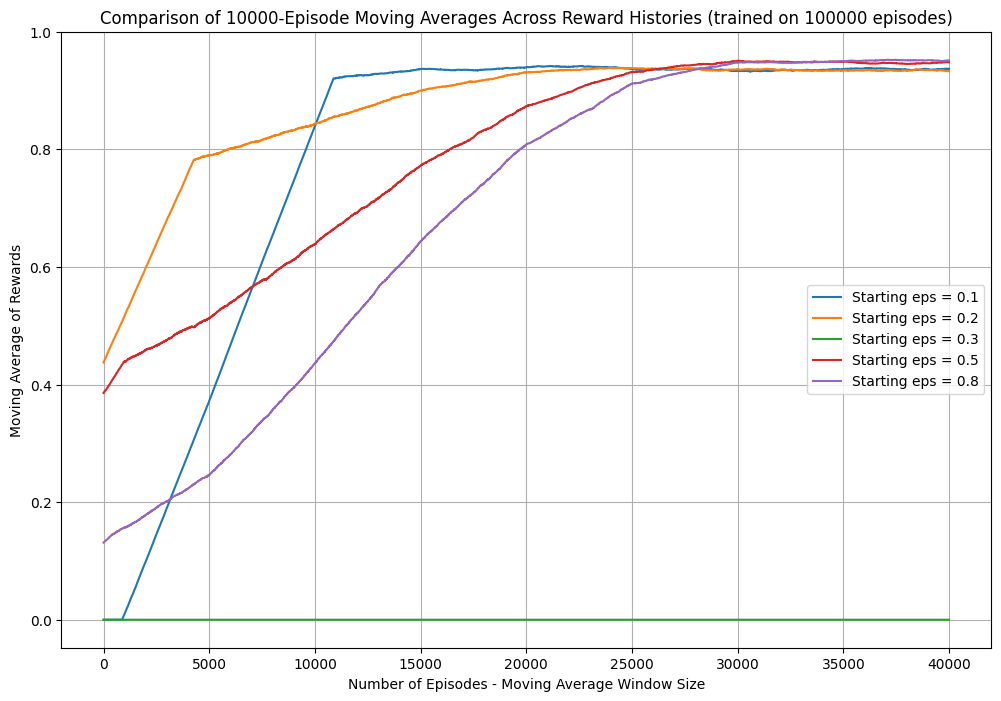

In [203]:
plot_moving_averages(fz_epsilon_data, nb_episodes=nb_episodes, moving_avg_size=int(nb_episodes/10))

Computing data with GLEI policy and starting epsilon = 0.1
Final epsilon: 0.05
Computing data with GLEI policy and starting epsilon = 0.2
Final epsilon: 0.05
Computing data with GLEI policy and starting epsilon = 0.3
Final epsilon: 0.05
Computing data with GLEI policy and starting epsilon = 0.5
Final epsilon: 0.05
Computing data with GLEI policy and starting epsilon = 0.8
Final epsilon: 0.07500000000000001


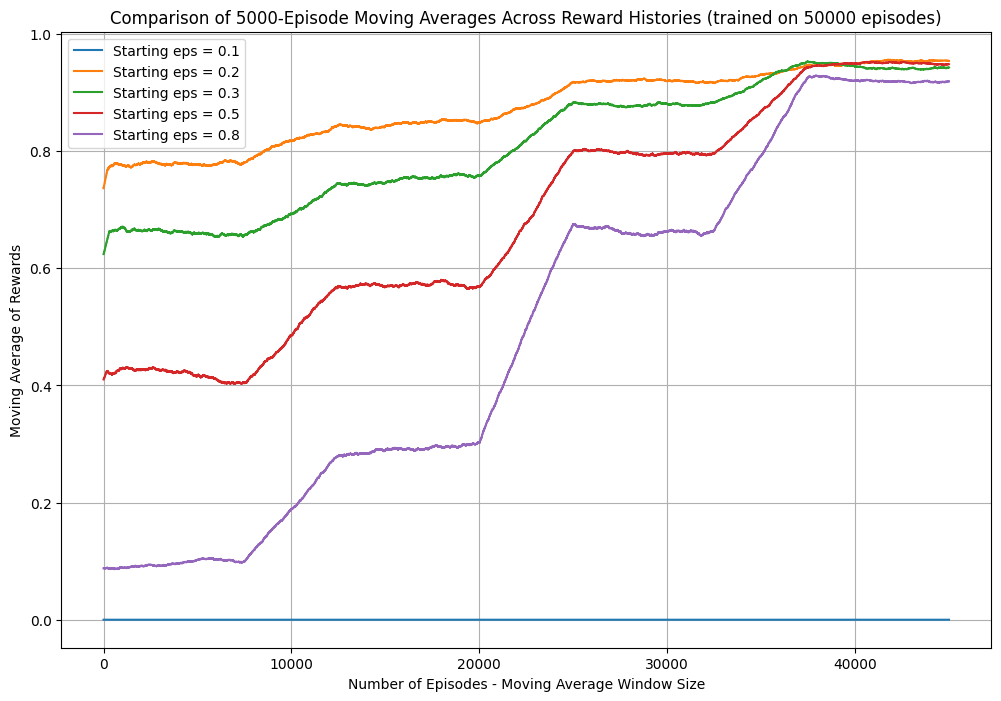

In [206]:
fz_epsilon_data = dict()
nb_episodes = 50000

for starting_eps in [0.1, 0.2, 0.3, 0.5, 0.8]:
# for eps in [0.5]:
    print(f"Computing data with GLEI policy and starting epsilon = {str(starting_eps)}")
    _, _, rewards_historic = on_policy_monte_carlo(
        env=fz_env,
        nb_states=fz_nb_states,
        nb_actions=fz_nb_actions,
        nb_episodes=nb_episodes,
        encode_fct=fz_encode,
        use_glei=True,
        epsilon=starting_eps,
        decay_rate=0.25, 
    )
    fz_epsilon_data[f"Starting eps = {str(starting_eps)}"] =  rewards_historic
plot_moving_averages(fz_epsilon_data, nb_episodes=nb_episodes, moving_avg_size=int(nb_episodes/10))

# 1. Black Jack

First of all, we will try the "on policy Monte Carlo" algorithm on the gymnasium black jack environment.  
See: https://gymnasium.farama.org/environments/toy_text/blackjack/

The state of the blackjack game is described by a triplet (s1, s2, a), where s1 is the sum of the points in the player's hand, s2 is the value of the dealer's visible card, and a is a boolean indicating whether the player has a usable ace.

## 1.1. Setting up environement

In [131]:
bj_env = gym.make("Blackjack-v1")
bj_nb_actions = bj_env.action_space.n
bj_nb_states = math.prod(space.n for space in bj_env.observation_space)
# maxSum is the maximum sum I can have in my hand
max_sum = 32
# maxOppScore is the maximum value of the card I can see from the opponent,
max_opp_score = 11

print("there are ", bj_nb_actions, "actions")
print("observation space: ", bj_env.observation_space)
print("there are ", bj_nb_states, "states")

there are  2 actions
observation space:  Tuple(Discrete(32), Discrete(11), Discrete(2))
there are  704 states


## 1.2. On policy Monte Carlo: learning an optimal policy

Avec les algorithmes "Value Iteration" ou "Policy Iteration", on aurait besoin de calculer la matrice de transition. Etant donné le nombre d'états, il serait probablement très fastidieux d'écrire cette matrice "à la main" ou bien d'écrire un programme pour calculer chaque probabilité exactement!

In [133]:
# Learning a policy
bj_policy, bj_q, bj_historic_rewards = on_policy_monte_carlo(
    env=bj_env,
    nb_states=bj_nb_states,
    nb_actions=bj_nb_actions,
    encode_fct=bj_encode,
    nb_episodes=500000,
    epsilon=0.1
)

In [134]:
# Evaluating our policy
bj_env_spec = gym.make("Blackjack-v1", render_mode = "human")

q, v, rewards_historic = every_visit_monte_carlo(
    env=bj_env, # use bj_env_spec to display the game in graphic interface
    nb_states=bj_nb_states,
    nb_actions=bj_nb_actions,
    policy=bj_policy,
    encode_fct=bj_encode,
)
print(f"Average Reward: {np.mean(rewards_historic)}")
print(f"Number of game won: {len([x for x in rewards_historic if x == 1])}")

Average Reward: -0.078
Number of game won: 423


## 1.3. Visualize

We can see the monte carlo algorithm is less efficient with a game like blackjack. Indeed, the high number of states require a high number of episodes to train. We can see that our algorithm may not explore every states (q values = 0)

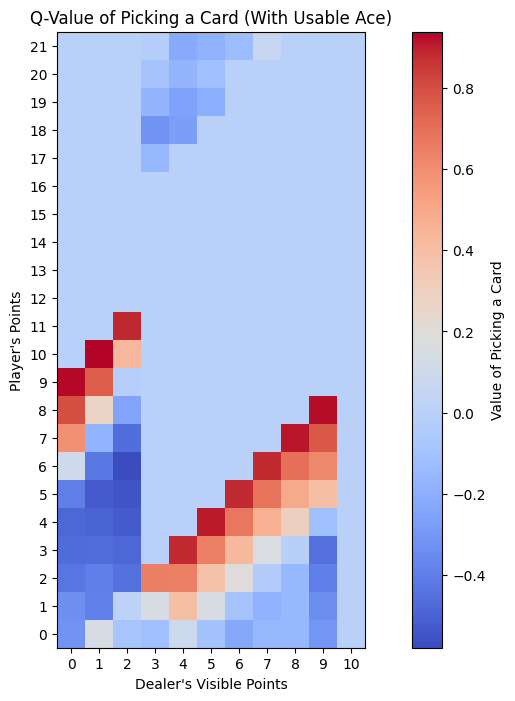

In [26]:
import numpy as np
import matplotlib.pyplot as plt

def plot_bj_q(q_values, nb_states, max_sum, max_opp_score):
    """
    Decode the Q-values and plot a 2D tableau for the player's hand value and dealer's card.

    Parameters:
    - q_values: The Q-values array from the Monte Carlo algorithm (state-action values).
    - nb_states: Total number of states in the environment.
    - max_sum: Maximum score the player can have in their hand.
    - max_opp_score: Maximum visible score of the opponent (dealer).
    """
    # Initialize the tableau
    q_tableau = np.zeros((max_sum + 1, max_opp_score + 1))

    # Decode the Q-values for each state
    for state_index in range(nb_states):
        # Decode the state
        player_points = state_index % max_sum
        dealer_points = (state_index // max_sum) % max_opp_score
        has_usable_ace = state_index >= max_sum * max_opp_score
        
        # Get the best action (e.g., to pick a card or not) based on Q-values
        best_action_value = np.max(q_values[state_index])
        
        # Update the tableau for this state
        if has_usable_ace:
            q_tableau[player_points, dealer_points] = best_action_value

    q_tableau = q_tableau[:22,]

    # Plot the tableau
    plt.figure(figsize=(12, 8))
    plt.imshow(q_tableau, interpolation="nearest", cmap="coolwarm", origin="lower")
    plt.colorbar(label="Value of Picking a Card")
    plt.title("Q-Value of Picking a Card (With Usable Ace)")
    plt.xlabel("Dealer's Visible Points")
    plt.ylabel("Player's Points")
    plt.xticks(ticks=np.arange(max_opp_score + 1), labels=np.arange(max_opp_score + 1))
    plt.yticks(ticks=np.arange(q_tableau.shape[0]), labels=np.arange(q_tableau.shape[0]))
    plt.grid(False)
    plt.show()

# Example usage
plot_bj_q(
    q_values=bj_q,
    nb_states=nb_states,
    max_sum=31,  # Assuming a max sum of 31 for player's hand
    max_opp_score=10  # Assuming max dealer card points is 10
)

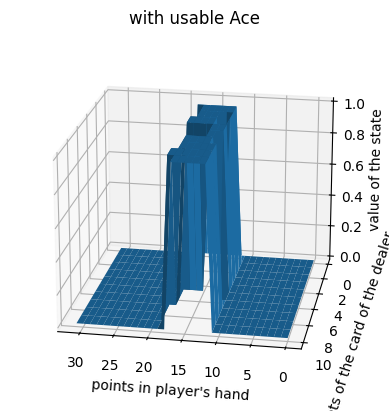

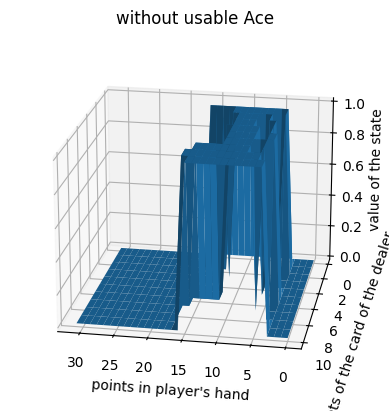

In [115]:
from mpl_toolkits.mplot3d import Axes3D  # Necessary for 3D plotting

x = np.arange(0,max_sum,1)
y = np.arange(0,max_opp_score,1)
# z1 for the states with usable ace
z1 = np.zeros((max_sum,max_opp_score))
# z2 for the states without usable ace
z2 = np.zeros((max_sum,max_opp_score))

bj_v = np.argmax(bj_q, axis = 1)
for i in range(max_sum):
  for j in range(max_opp_score):
    index = bj_encode([i,j,True])
    z1[i,j] =  bj_v[index]
    index = bj_encode([i,j,False])
    z2[i,j] =  bj_v[index]

xx, yy = np.meshgrid(x,y)
# First plot
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")  # Use add_subplot with projection='3d'
ax.plot_surface(xx, yy, z1[:, :].T)
ax.view_init(20, 100)
plt.title("with usable Ace")
plt.xlabel("points in player's hand")
plt.ylabel("points of the card of the dealer")
ax.set_zlabel("value of the state")
plt.show()

# Second plot
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")  # Use add_subplot with projection='3d'
ax.plot_surface(xx, yy, z2[:, :].T)
ax.view_init(20, 100)
plt.title("without usable Ace")
plt.xlabel("points in player's hand")
plt.ylabel("points of the card of the dealer")
ax.set_zlabel("value of the state")
plt.show()

## 1.4. Tuning hyper parameters

### 1.4.1 Compute with simple  eps-greedy policy

In [122]:
bj_epsilon_data = dict()
nb_episodes = 100000

for eps in [0.0125, 0.025, 0.1, 0.2, 0.4, 0.5]:
# for eps in [0.5]:
    print(f"Computing data for epsilon = {str(eps)}")
    _, _, rewards_historic = on_policy_monte_carlo(
        env=bj_env,
        nb_states=bj_nb_states,
        nb_actions=bj_nb_actions,
        nb_episodes=nb_episodes,
        encode_fct=bj_encode,
        epsilon=eps
    )
    bj_epsilon_data[str(eps)] =  rewards_historic

Computing data for epsilon = 0.0125
100000 episodes computed
Computing data for epsilon = 0.025
100000 episodes computed
Computing data for epsilon = 0.5
100000 episodes computed
Computing data for epsilon = 0.1
100000 episodes computed
Computing data for epsilon = 0.2
100000 episodes computed
Computing data for epsilon = 0.4
100000 episodes computed


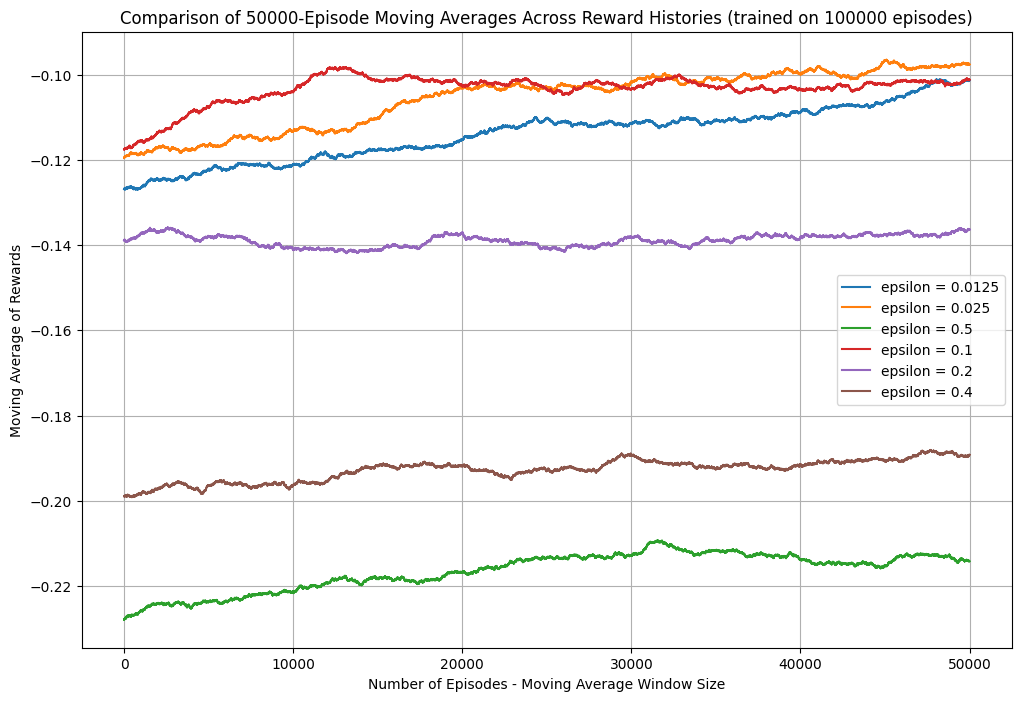

In [123]:
plot_moving_averages(bj_epsilon_data, nb_episodes=nb_episodes, moving_avg_size=int(nb_episodes/2))

### 1.4.2. Compute with GLEI policy

In [211]:
bj_epsilon_data = dict()
nb_episodes = 100000

for starting_eps in [0.0125, 0.025, 0.1, 0.2, 0.4, 0.5]:
# for eps in [0.5]:
    print(f"Computing data with GLEI policy and starting epsilon = {str(starting_eps)}")
    _, _, rewards_historic = on_policy_monte_carlo(
        env=bj_env,
        nb_states=bj_nb_states,
        nb_actions=bj_nb_actions,
        nb_episodes=nb_episodes,
        encode_fct=bj_encode,
        use_glei=True,
        epsilon=starting_eps,
        decay_rate=0.1,
        min_epsilon=0.005
    )
    bj_epsilon_data[f"Starting eps = {str(starting_eps)}"] =  rewards_historic

Computing data with GLEI policy and starting epsilon = 0.0125
Final epsilon: 0.005
Computing data with GLEI policy and starting epsilon = 0.025
Final epsilon: 0.005
Computing data with GLEI policy and starting epsilon = 0.1
Final epsilon: 0.005
Computing data with GLEI policy and starting epsilon = 0.2
Final epsilon: 0.005
Computing data with GLEI policy and starting epsilon = 0.4
Final epsilon: 0.005
Computing data with GLEI policy and starting epsilon = 0.5
Final epsilon: 0.005


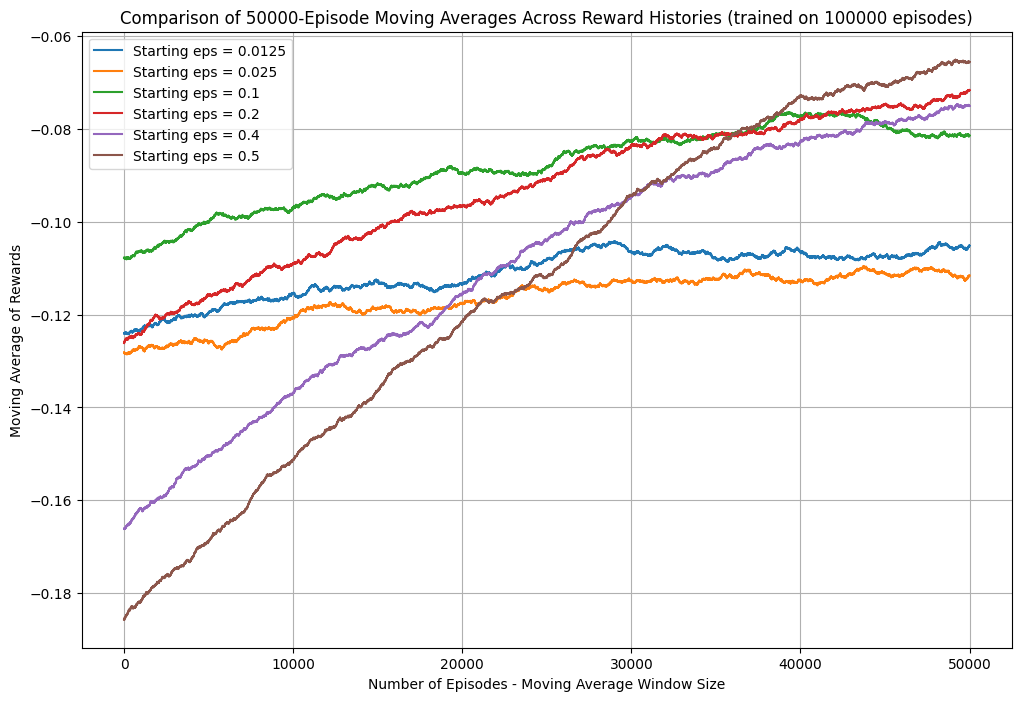

In [212]:
plot_moving_averages(bj_epsilon_data, nb_episodes=nb_episodes, moving_avg_size=int(nb_episodes/2))

# 3. Sandbox

## Building every_visit_monte_carlo function

In [ ]:
def every_visit_monte_carlo(env, nb_states, nb_actions, policy, nb_episodes = 1000):
    """
    - "Every visit" version of Monte Carlo algorithm which consists of evaluating the values of each (states, actions) for a given policy.
    - This version of the algorithm raises the problem that the values q(s, a) are not necessarily i.i.d.
      Indeed, visiting the same state multiple times during an episode is certainly dependent on the episode's history.
      Convergence despite dependance is guaranteed in this paper: https://sites.ualberta.ca/~szepesva/papers/sarsa98.ps.pdf

    Args:
        game_name (str): the game name with wich gymnasium env is initiliazed
        nb_episodes (int): number of episodes simulated
        policy (callable): a function representing the policy followed
    
    Returns:
        q (numpy.array 2D): the array of values q(states, actions)
        v (numpy.array 1D): the array of values v(states) which is the max_a[q(s, a)]
    """
    # Initializing algorithm variables
    q = np.zeros(shape = (nb_states, nb_actions)) # (state, action) values through every episodes generated
    count = np.zeros(shape = (nb_states, nb_actions)) # Counting each (s, a) events through every episodes generated
    acc = np.zeros(shape = (nb_states, nb_actions)) # (state, action) cumulated values through every episodes generated

    # Repeat for the given number of episodes:
    #       Simulate an episode with the given policy
    #       Accumulate the rewards: G
    #       For every visit of state s:
    #           acc(s) += G
    #           count(s) += 1
    #           v(s) = acc(s) / count(s)
    for i in range(nb_episodes):
        # Initializing environment
        game_state = env.reset()[0] # A tuple (player score, opponent score, ace (1) or not (0))
        terminated = False
        G = 0 # Cumulated rewards for the current episode

        # Simulating an episode
        while not(terminated):
            # Play an action according to the given policy
            action = policy(game_state)
            env_state = env.step(action)

            # Updating variables according to the action chosen
            state_index, G, terminated = encode(env_state[0]), G + env_state[1], env_state[2]

        # Updating q(s, a) value
        acc[state_index, action] += G 
        count[state_index, action] += 1
        q[state_index, action] = acc[state_index, action] / count[state_index, action]
    
    return q, np.max(q, axis = 1)

## Testing functions of "on policy monte carlo" algorithm

In [ ]:
import numpy as np

# Example policy
policy = np.array([0.2, 0.5, 0.3])  # Probabilities must sum to 1

# Draw actions multiple times to check distribution
results = [draw(policy) for _ in range(10000)]

# Calculate frequencies
unique, counts = np.unique(results, return_counts=True)
frequencies = counts / sum(counts)

# Display results
print("Frequencies of actions:", dict(zip(unique, frequencies)))

Frequencies of actions: {0: 0.1923, 1: 0.5026, 2: 0.3051}


In [ ]:
# Test the epsilon_greedy function

q_values = np.array([1, 2, 3, 3, 2])  # q-values for a state
epsilon = 0.1  # 10% chance to pick randomly

# Test epsilon-greedy over 1000 iterations
n_iterations = 100000
actions = []

for _ in range(n_iterations):
    action = epsilon_greedy(epsilon, q_values)
    actions.append(action)

# Calculate frequencies
actions = np.array(actions)
unique, counts = np.unique(actions, return_counts=True)
frequencies = counts / n_iterations

print(f"Action frequencies after {n_iterations} iterations:")
for action, freq in zip(unique, frequencies):
    print(f"Action {action}: {freq:.2f}")


Action frequencies after 100000 iterations:
Action 0: 0.02
Action 1: 0.02
Action 2: 0.47
Action 3: 0.47
Action 4: 0.02


## On policy Monte Carlo: Some tests

In [ ]:
# Function variable
nb_episodes = 100000
gamma = 1
epsilon = 0.8

# Algorithm
# Initialize algorithm variables
q = np.zeros(shape = (nb_states, nb_actions)) # (state, action) values through every episodes generated
count = np.zeros(shape = (nb_states, nb_actions)) # Counting each (s, a) events through every episodes generated
acc = np.zeros(shape = (nb_states, nb_actions)) # (state, action) cumulated values through every episodes generated
policy = np.full(shape = (nb_states, nb_actions), fill_value = 1/nb_actions) # Actions probabilities for each state. Initialized as a uniform policy

# Repeat for the given number of episodes:
#       Simulate an episode with the given policy
#       Accumulate the rewards: G
#       For every visited q(s, a) in the current episode:
#           If first visit of (s, a):
#               acc(s, a) += G
#               count(s, a) += 1
#               q(s, a) = acc(s, a) / count(s, a)
#           For every state in the current episode:
#               update policy(s, a) with an epsilon greedy strategy
breakp = -1
for num_episode in range(nb_episodes):
    # print(f"Episode {num_episode}")
    if breakp == 1:
        print("breakp")

    # Initialize environment
    game_state = env.reset()[0] # A tuple (player score, opponent score, ace (1) or not (0))
    terminated = False
    G = 0 # Cumulated rewards of the current episode
    historic = np.empty((0, 2), dtype=int)  # Historic of (state, action) of the current episode
    
    # Simulate an episode
    while not(terminated):
        # Draw an action according to the current state and update historic
        state_index = encode(game_state)
        action = draw(policy[state_index])

        # Update environment with the chosen action
        env_state = env.step(action)
        game_state, G, terminated = env_state[0], G + env_state[1], env_state[2]

        # If current (s, a) is not visited yet
        if not(np.any(np.all(historic == [state_index, action], axis=1))):
            acc[state_index, action] += G 
            count[state_index, action] += 1
            q[state_index, action] = acc[state_index, action] / count[state_index, action]
        
        if G == 1:
            print("bp")
        # Update policy with argmax_a[q(s, a)]
        policy[state_index] = update_eps_greedy_policy(epsilon=epsilon, q=q[state_index])

        # Update current historic
        historic = np.append(historic, [[state_index, action]], axis = 0)

        breakp = G

print(f"{nb_episodes} episodes computed")
v = np.max(q, axis=1)
print(v)
print(policy)
# count_wins, avg_return = evaluate_policy(policy, env)
print(f"Average Return: {avg_return}")
print(f"Number of game won: {count_wins}")